<a href="https://colab.research.google.com/github/rohanjadhav41193/MachineLearningPart2/blob/ml2projects/GarbageClassificationDenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
import glob, os, random
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt
from google.colab import drive
import pathlib
import tensorflow as tf
from sklearn.metrics import f1_score
import sklearn.metrics
import matplotlib.image as mpimg
from tensorflow.keras.applications.xception import preprocess_input
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import pandas as pd

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [17]:
drive.mount('/content/drive',force_remount=True)
directory = 'drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/'
os.listdir(directory)  # shows the subfolders I had shared with me

Mounted at /content/drive


['one-indexed-files-notrash_val.txt',
 'one-indexed-files.txt',
 'zero-indexed-files.txt',
 'one-indexed-files-notrash_train.txt',
 'one-indexed-files-notrash_test.txt',
 'trash',
 'plastic',
 'metal',
 'glass',
 'paper',
 'cardboard']

In [18]:
Name=[]
for file in os.listdir(directory):
  if os.path.isdir(os.path.join(directory,file)):
    Name+=[file]
    
print(Name)
print(len(Name))

['trash', 'plastic', 'metal', 'glass', 'paper', 'cardboard']
6


In [19]:
for label in Name:
    base_directory = os.path.join(directory, label)
    print(base_directory)
    print("Images of label \"" + label + "\":\t", len(os.listdir(base_directory)))

drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/trash
Images of label "trash":	 137
drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/plastic
Images of label "plastic":	 482
drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/metal
Images of label "metal":	 410
drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/glass
Images of label "glass":	 501
drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/paper
Images of label "paper":	 594
drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/cardboard
Images of label "cardboard":	 403


In [20]:
def load_csv(subset):
    
    if subset == 'train':
        fname = directory + 'one-indexed-files-notrash_train.txt'
    elif subset == 'validation':
        fname = directory + 'one-indexed-files-notrash_val.txt'
    elif subset == 'test':
        fname = directory + 'one-indexed-files-notrash_test.txt'
    else:
        raise ValueError('subset must be "train", "validation" or "test"')
    
    df = pd.read_csv(fname, sep=' ', names=['file', 'label'])
    
    # change the labels to be from 0 to 5
    df['label'] -= 1
    
    # create path column
    df['folder'] = [Name[i] for i in df['label']]
    df['path'] = df['folder'] + df['file']
    
    # change type of label for datagenerator
    df['label_str'] = df['label'].astype(str)
    
    return df

In [27]:
def plot_cm(y_true, y_pred, title, classes):
    '''
    Fancy confusion matrix plot.
    '''
    y_pred = y_pred.astype(int)
    
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig, ax = plt.subplots()
    plt.title(title)
    sns.heatmap(cm, cmap='viridis', annot=annot, fmt='', ax=ax)

In [21]:
# Read all the csv files
df_train = load_csv('train')
df_valid = load_csv('validation')
df_test = load_csv('test')

df_train.head()

,file,label,folder,path,label_str
0,cardboard202.jpg,2,metal,metalcardboard202.jpg,2
1,paper472.jpg,1,plastic,plasticpaper472.jpg,1
2,paper522.jpg,1,plastic,plasticpaper522.jpg,1
3,glass189.jpg,0,trash,trashglass189.jpg,0
4,glass325.jpg,0,trash,trashglass325.jpg,0


Text(0, 0.5, 'population')

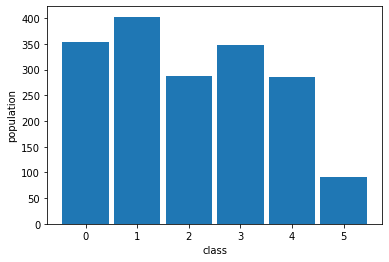

In [22]:
plt.hist(df_train['label'], bins=np.arange(7)-0.5, rwidth=0.9)
plt.xlabel('class')
plt.ylabel('population')

Text(0, 0.5, 'Class weight')

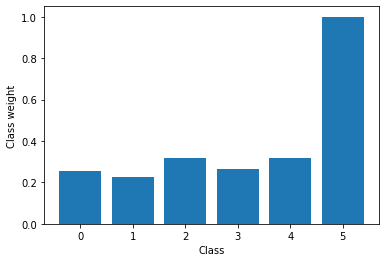

In [23]:
hist, _ = np.histogram(df_train['label'], bins=np.arange(7)-0.5)
class_weight = hist.min()/hist
class_weight = {i:class_weight[i] for i in range(6)}

plt.bar(np.arange(6), [class_weight[i] for i in range(6)])
plt.xlabel('Class')
plt.ylabel('Class weight')

In [4]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [32]:
dataset=[]
count=0
for file in os.listdir(directory):
  if os.path.isdir(os.path.join(directory,file)):
    path=os.path.join(directory,file)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(60,60))
        image=img_to_array(image)
        image=image/255.0
        dataset+=[[image,count]]
    count=count+1
print(count)

6


In [33]:
n=len(dataset)
print(n)

2527


In [34]:
num=[]
for i in range(n):
    num+=[i]
random.shuffle(num)
print(num[0:5])

[1621, 499, 1944, 2250, 2415]


In [35]:
data,labels=zip(*dataset)
data=np.array(data)
labels=np.array(labels)

train=data[num[0:(n//10)*8]]
trainlabel=labels[num[0:(n//10)*8]]

test=data[num[(n//10)*8:]]
testlabel=labels[num[(n//10)*8:]]

In [36]:
trainlabel2=to_categorical(trainlabel)

In [37]:
trainx,testx,trainy,testy=train_test_split(train,trainlabel2,test_size=0.2,random_state=44)

In [38]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(1612, 60, 60, 3)
(404, 60, 60, 3)
(1612, 6)
(404, 6)


In [39]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [40]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(60,60,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

In [41]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(6, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [42]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=20)

Epoch 1/20
51/51 [==============================] - 44s 544ms/step - loss: 1.4345 - accuracy: 0.4454 - val_loss: 1.2558 - val_accuracy: 0.5000
Epoch 2/20
51/51 [==============================] - 24s 479ms/step - loss: 1.2360 - accuracy: 0.5323 - val_loss: 1.1260 - val_accuracy: 0.5891
Epoch 3/20
51/51 [==============================] - 22s 441ms/step - loss: 1.1668 - accuracy: 0.5540 - val_loss: 1.0853 - val_accuracy: 0.5891
Epoch 4/20
51/51 [==============================] - 23s 458ms/step - loss: 1.0879 - accuracy: 0.5999 - val_loss: 1.0456 - val_accuracy: 0.6015
Epoch 5/20
51/51 [==============================] - 24s 470ms/step - loss: 1.0206 - accuracy: 0.6203 - val_loss: 1.0253 - val_accuracy: 0.6040
Epoch 6/20
51/51 [==============================] - 24s 466ms/step - loss: 1.0026 - accuracy: 0.6452 - val_loss: 0.9984 - val_accuracy: 0.6139
Epoch 7/20
51/51 [==============================] - 24s 468ms/step - loss: 0.9700 - accuracy: 0.6346 - val_loss: 1.0503 - val_accuracy: 0.5792

In [30]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

NameError: ignored

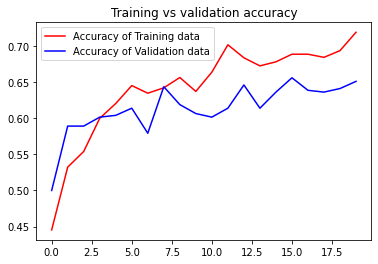

<Figure size 432x288 with 0 Axes>

In [46]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

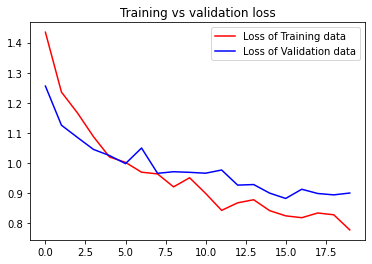

<Figure size 432x288 with 0 Axes>

In [47]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [29]:
plot_cm(df_test['label'], testy, 'Test\nf1_score=' + str('%.3f' %score_test), classes)

NameError: ignored

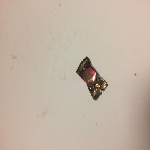

In [49]:
load_img("drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/trash/trash122.jpg",target_size=(150,150))

In [50]:
image=load_img("drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/trash/trash122.jpg",target_size=(60,60))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [51]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
print("Prediction is {}.".format(move_name))

Prediction is trash.


In [52]:
print(test.shape)
pred2=model.predict(test)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

(511, 60, 60, 3)
(511, 6)


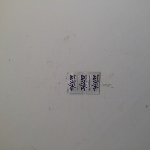

In [53]:
load_img("drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/plastic/plastic481.jpg",target_size=(150,150))

In [54]:
image=load_img("drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/plastic/plastic481.jpg",target_size=(60,60))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [55]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
print("Prediction is {}.".format(move_name))

Prediction is plastic.


In [56]:
print(test.shape)
pred2=model.predict(test)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

(511, 60, 60, 3)
(511, 6)


# Implementation of CNN base model 


In [58]:
img_list = glob.glob(os.path.join(directory, '*/*.jpg'))

print(len(img_list))

2527


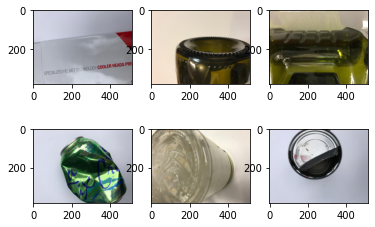

In [60]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    "drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification",
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    "drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification",
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [8]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        9

# Taking First Shot

In [66]:
model.fit_generator(train_generator, epochs=20, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
143/143 [==============================] - 355s 2s/step - loss: 1.6264 - acc: 0.3194 - val_loss: 1.4895 - val_acc: 0.3546
Epoch 2/20
143/143 [==============================] - 352s 2s/step - loss: 1.4261 - acc: 0.4086 - val_loss: 1.4501 - val_acc: 0.3825
Epoch 3/20
143/143 [==============================] - 349s 2s/step - loss: 1.3417 - acc: 0.4565 - val_loss: 1.3097 - val_acc: 0.4382
Epoch 4/20
143/143 [==============================] - 348s 2s/step - loss: 1.2737 - acc: 0.4917 - val_loss: 1.2862 - val_acc: 0.4622
Epoch 5/20
143/143 [==============================] - 349s 2s/step - loss: 1.2313 - acc: 0.5242 - val_loss: 1.3037 - val_acc: 0.4821
Epoch 6/20
143/143 [==============================] - 331s 2s/step - loss: 1.2250 - acc: 0.5198 - val_loss: 1.2321 - val_acc: 0.5219
Epoch 7/20
143/143 [==============================] - 331s 2s/step - loss: 1.1191 - acc: 0.5747 - val_loss: 1.1972 - val_acc: 0.5777
Epoch 8/20
143/143 [==============================] - 332s 2s/step - 

# Taking Second Shot

In [67]:
model.fit_generator(train_generator, epochs=20, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
143/143 [==============================] - 324s 2s/step - loss: 0.6720 - acc: 0.7597 - val_loss: 0.9952 - val_acc: 0.6614
Epoch 2/20
143/143 [==============================] - 325s 2s/step - loss: 0.6596 - acc: 0.7588 - val_loss: 0.9151 - val_acc: 0.6892
Epoch 3/20
143/143 [==============================] - 324s 2s/step - loss: 0.6349 - acc: 0.7728 - val_loss: 1.1256 - val_acc: 0.6375
Epoch 4/20
143/143 [==============================] - 324s 2s/step - loss: 0.6178 - acc: 0.7755 - val_loss: 0.7926 - val_acc: 0.6853
Epoch 5/20
143/143 [==============================] - 324s 2s/step - loss: 0.5975 - acc: 0.7856 - val_loss: 0.8119 - val_acc: 0.7291
Epoch 6/20
143/143 [==============================] - 323s 2s/step - loss: 0.6100 - acc: 0.7851 - val_loss: 0.7797 - val_acc: 0.7251
Epoch 7/20
143/143 [==============================] - 321s 2s/step - loss: 0.5690 - acc: 0.7935 - val_loss: 0.8352 - val_acc: 0.7251
Epoch 8/20
143/143 [==============================] - 324s 2s/step - 

# Taking Third Shot

In [68]:
model.fit_generator(train_generator, epochs=20, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
143/143 [==============================] - 320s 2s/step - loss: 0.4323 - acc: 0.8445 - val_loss: 0.7353 - val_acc: 0.7610
Epoch 2/20
143/143 [==============================] - 322s 2s/step - loss: 0.4278 - acc: 0.8515 - val_loss: 1.1106 - val_acc: 0.6693
Epoch 3/20
143/143 [==============================] - 321s 2s/step - loss: 0.4437 - acc: 0.8383 - val_loss: 0.8106 - val_acc: 0.7410
Epoch 4/20
143/143 [==============================] - 322s 2s/step - loss: 0.3870 - acc: 0.8660 - val_loss: 0.9123 - val_acc: 0.7251
Epoch 5/20
143/143 [==============================] - 322s 2s/step - loss: 0.3885 - acc: 0.8563 - val_loss: 0.9304 - val_acc: 0.6892
Epoch 6/20
143/143 [==============================] - 322s 2s/step - loss: 0.3912 - acc: 0.8638 - val_loss: 0.8893 - val_acc: 0.7610
Epoch 7/20
143/143 [==============================] - 320s 2s/step - loss: 0.3862 - acc: 0.8682 - val_loss: 1.1817 - val_acc: 0.6733
Epoch 8/20
143/143 [==============================] - 320s 2s/step - 

# Taking Fourth Shot

In [69]:
model.fit_generator(train_generator, epochs=20, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
143/143 [==============================] - 320s 2s/step - loss: 0.3271 - acc: 0.8919 - val_loss: 0.7775 - val_acc: 0.7610
Epoch 2/20
143/143 [==============================] - 320s 2s/step - loss: 0.3519 - acc: 0.8743 - val_loss: 0.6805 - val_acc: 0.7968
Epoch 3/20
143/143 [==============================] - 318s 2s/step - loss: 0.3144 - acc: 0.8888 - val_loss: 0.9500 - val_acc: 0.6892
Epoch 4/20
143/143 [==============================] - 319s 2s/step - loss: 0.3260 - acc: 0.8770 - val_loss: 0.7684 - val_acc: 0.7809
Epoch 5/20
143/143 [==============================] - 320s 2s/step - loss: 0.3003 - acc: 0.8946 - val_loss: 0.7891 - val_acc: 0.7171
Epoch 6/20
143/143 [==============================] - 319s 2s/step - loss: 0.2675 - acc: 0.9130 - val_loss: 0.8041 - val_acc: 0.7610
Epoch 7/20
143/143 [==============================] - 318s 2s/step - loss: 0.2752 - acc: 0.9011 - val_loss: 1.0333 - val_acc: 0.7490
Epoch 8/20
143/143 [==============================] - 317s 2s/step - 

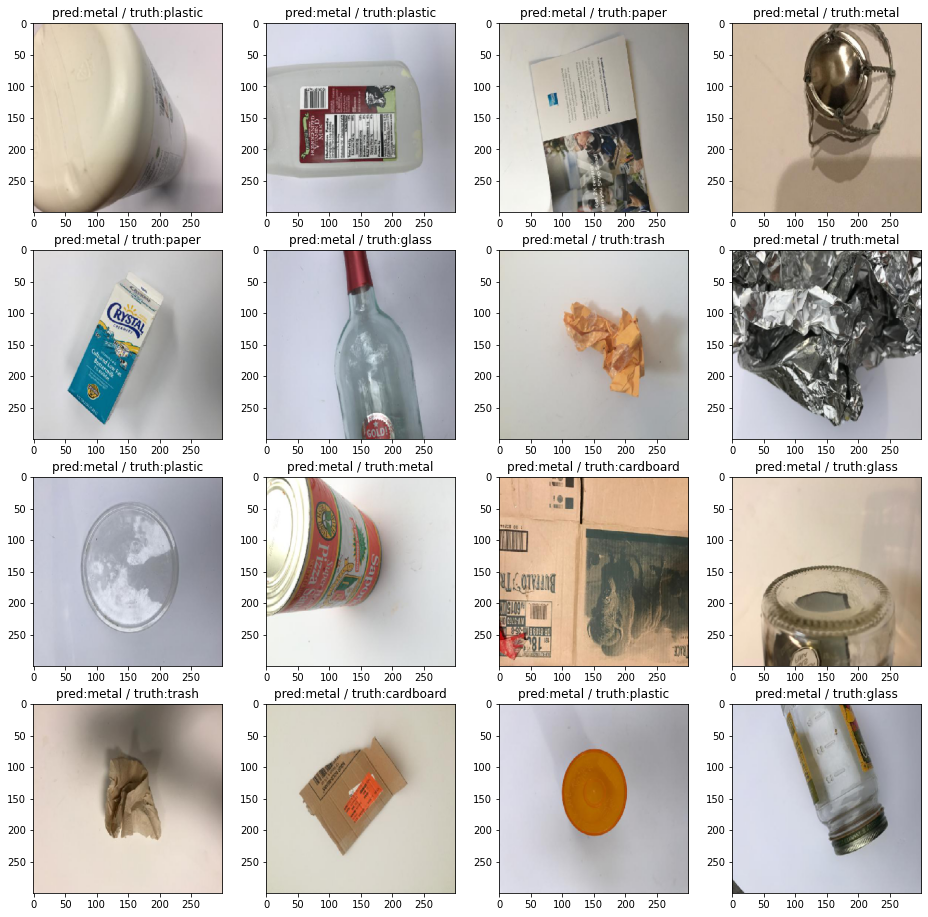

In [32]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [41]:
y_pred=model.predict(test_x)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(test_y,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.19      1.00      0.32         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2

    accuracy                           0.19        16
   macro avg       0.03      0.17      0.05        16
weighted avg       0.04      0.19      0.06        16



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
pred_valid = np.argmax(model.predict(valid_datagen), axis=1)
pred_test = np.argmax(model.predict(test_datagen), axis=1)

score_valid = f1_score(df_valid['label'], pred_valid, average='macro')
score_test = f1_score(df_test['label'], pred_test, average='macro')

NameError: ignored